# Processing our data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from tqdm import tqdm

In [2]:
radio_ml_2016 = pd.read_pickle('../data/radio_ml_2016/RML2016.10a_dict.pkl')

In [3]:
radio_ml_2016[('QPSK', 10)].shape

(1000, 2, 128)

In [4]:
mods_snrs = list(radio_ml_2016.keys())
key = mods_snrs[0]
samples = radio_ml_2016[key]
print(key, samples.shape)

('QPSK', 2) (1000, 2, 128)


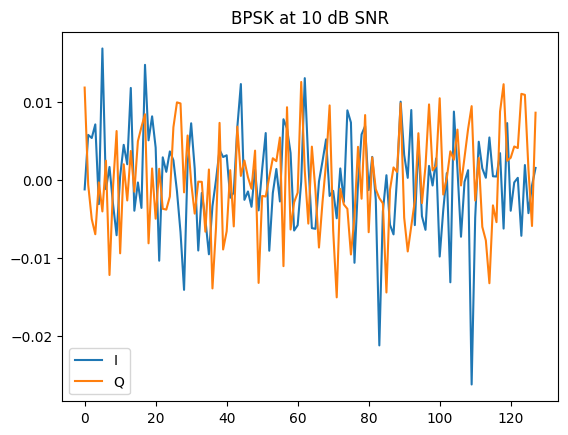

In [5]:
iq_sample = radio_ml_2016[('BPSK', 10)][0]
i = iq_sample[0]
q = iq_sample[1]

plt.plot(i, label='I')
plt.plot(q, label='Q')
plt.legend()
plt.title("BPSK at 10 dB SNR")
plt.show()


In [6]:
def add_gaussian_noise(iq_samples, noise_std=0.01):
    noise = noise_std * np.random.randn(*iq_samples.shape)
    return iq_samples + noise

In [7]:
def random_phase_shift(iq_samples, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(iq_samples, shift, axis=-1)

In [8]:
def random_amplitude_scaling(iq_samples, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(*scale_range)
    return iq_samples * scale

In [9]:
def augment_iq_sample(iq_sample):
    augmented_res = add_gaussian_noise(iq_sample, noise_std=0.02)
    augmented_res = random_phase_shift(augmented_res, max_shift=3)
    augmented_res = random_amplitude_scaling(augmented_res)
    return augmented_res

In [10]:
for key in tqdm(mods_snrs, desc="Normalizing & Scaling raw IQ data"):
    samples = radio_ml_2016[key]
    num_samples = samples.shape[0]

    for i in range(num_samples):
        for ch in range(samples.shape[1]):
            channel_data = samples[i, ch, :]
            mean = channel_data.mean()
            std = channel_data.std()
            samples[i, ch, :] = (channel_data - mean) / (std + 1e-10)
    
    data_reshaped = samples.transpose(0, 2, 1).reshape(-1, 2)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_reshaped)
    scaled_data = scaled_data.reshape(num_samples, 128, 2).transpose(0, 2, 1)
    radio_ml_2016[key] = scaled_data

    augmented_samples = np.empty_like(scaled_data)
    for i in range(num_samples):
        augmented_samples[i] = augment_iq_sample(scaled_data[i])
    radio_ml_2016[key] = augmented_samples

Normalizing & Scaling raw IQ data: 100%|████████████████████████████████████████████████████| 220/220 [00:20<00:00, 10.61it/s]


In [11]:
def generate_spectrogram(iq_sample, fs=1.0, nperseg=32, noverlap=16):
    spec_channels = []
    for ch in range(iq_sample.shape[0]):
        f, t, Sxx = spectrogram(iq_sample[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        Sxx = np.abs(Sxx)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        spec_channels.append(Sxx_db)

    spectrogram_img = np.stack(spec_channels, axis=0)
    return spectrogram_img

In [12]:
spectrograms_dict = {}

for key in tqdm(mods_snrs, desc="Generating spectrograms"):
    samples = radio_ml_2016[key]
    spectrograms = []
    for i in range(samples.shape[0]):
        spec_img = generate_spectrogram(samples[i])
        spectrograms.append(spec_img)
    spectrograms = np.array(spectrograms)
    spectrograms_dict[key] = spectrograms

Generating spectrograms: 100%|██████████████████████████████████████████████████████████████| 220/220 [01:09<00:00,  3.14it/s]


In [13]:
for key, specs in spectrograms_dict.items():
    print(f"Key: {key}")
    print(f" Number of samples: {specs.shape[0]}")
    print(f" Spectrogram shape per sample: {specs.shape[1:]}")
    print(f" Min value: {specs.min():.4f}")
    print(f" Max value: {specs.max():.4f}")
    print(f" Mean value: {specs.mean():.4f}")
    print(f" NaNs present: {np.isnan(specs).any()}")
    print(f" Infinite values present: {np.isinf(specs).any()}")
    print("-" * 30)

Key: ('QPSK', 2)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 7)
 Min value: -100.0000
 Max value: 18.8754
 Mean value: -6.7270
 NaNs present: False
 Infinite values present: False
------------------------------
Key: ('PAM4', 8)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 7)
 Min value: -97.8973
 Max value: 19.8327
 Mean value: -15.0682
 NaNs present: False
 Infinite values present: False
------------------------------
Key: ('AM-DSB', -4)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 7)
 Min value: -93.3727
 Max value: 13.9937
 Mean value: -0.7759
 NaNs present: False
 Infinite values present: False
------------------------------
Key: ('GFSK', 6)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 7)
 Min value: -91.2581
 Max value: 18.8359
 Mean value: -11.5778
 NaNs present: False
 Infinite values present: False
------------------------------
Key: ('QAM64', 8)
 Number of samples: 1000
 Spectrogram shape per sample: 

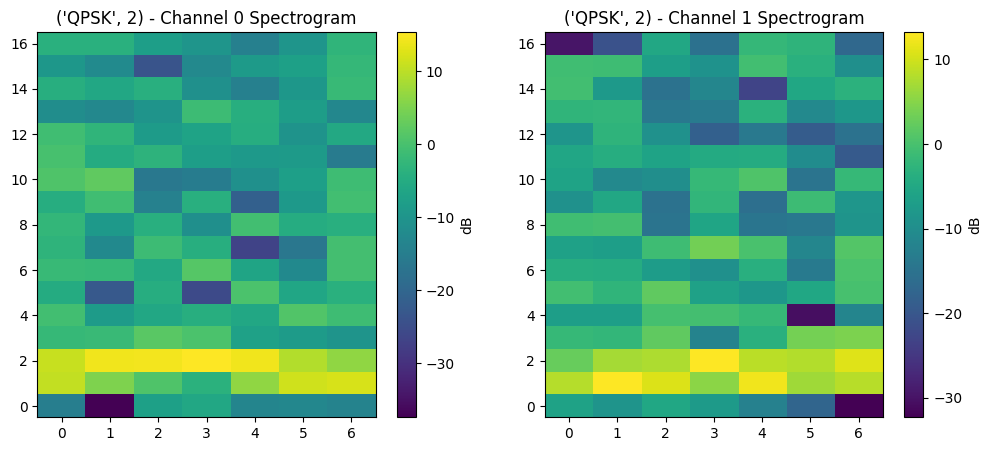

In [14]:
key = list(spectrograms_dict.keys())[0]
sample_idx = 0
spec = spectrograms_dict[key][sample_idx]
plt.figure(figsize=(12, 5))
for ch in range(spec.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f"{key} - Channel {ch} Spectrogram")
    plt.imshow(spec[ch], aspect='auto', origin='lower')
    plt.colorbar(label='dB')
plt.show()

In [20]:
print(list(spectrograms_dict.keys())[:5])

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8)]


In [21]:
radio_ml_2016_str_keys = {
    str(key): value for key, value in radio_ml_2016.items()
}

spectrograms_dict_str_keys = {
    str(key): value for key, value in spectrograms_dict.items()
}

In [22]:
np.savez_compressed("../data/processed_iq_data.npz", **radio_ml_2016)

TypeError: keywords must be strings

In [23]:
np.savez_compressed("../data/spectrograms.npz", **spectrograms_dict)

TypeError: keywords must be strings